# Infusing Intentional Diversity into Simple Recommendation Systems

If you are chronically online like me, you've probably noticed that social media algorithms tend to niche down really quickly.

For example, I don't know how I ended up on Scottish Sheep Farmer TikTok, but I'm invested.

My favorite farmer, [@seanthesheepman](https://www.tiktok.com/@seanthesheepman?lang=en),  posts weekly updates of his dog Katie and her sheep and the content always manages to bring me some joy.

However, there was a period of time where the vast majority of content recommended to me was about Scottish sheep and only Scottish sheep.

Moments like this can be frustrating for users.

From racial diversity to content diversity, we know that all content-driven platforms can do better.

As data scientists, we participate in this conversation in the form of building infrastructure that allows users to access interesting and novel content.

# Business Problem

Early recommendation algorithms were evaluated based on accuracy. If a user rates Captain America 5 stars, it's technically accurate to recommend all Avengers movies, but it makes for a boring platform.

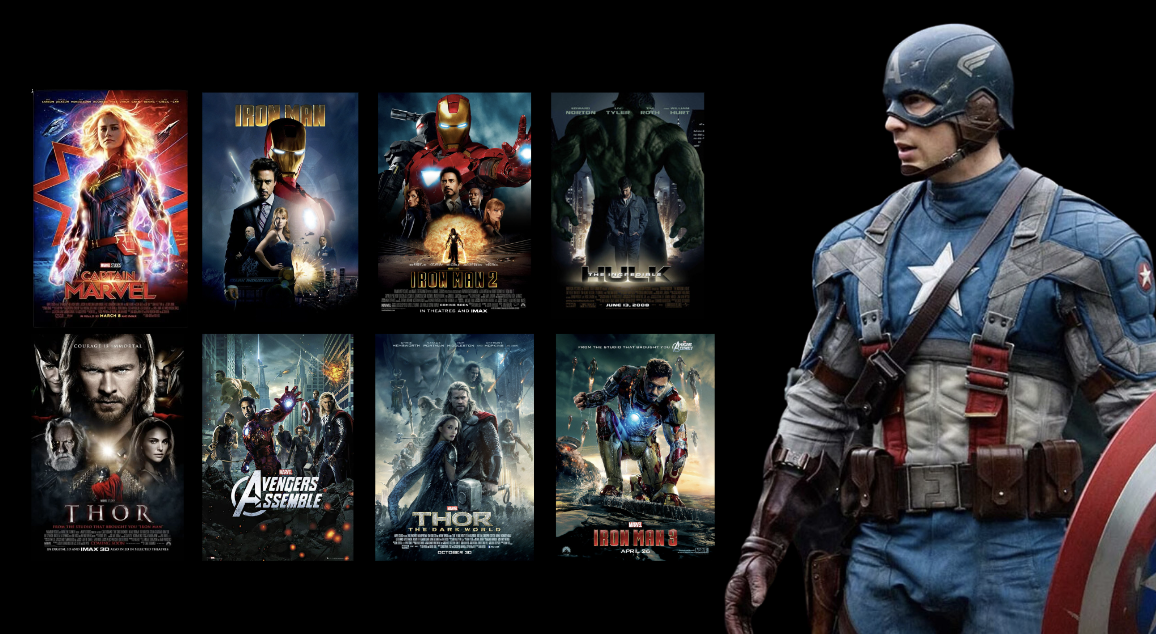

## Intentional Diversity

As Data Scientists, we often don't have enough information to understand why exactly users choose one video over another. There are a myriad of reasons why content driven by minorities underperforms on various platforms. In each instance, we don't know if users aren't watching because they have some bias or because they are unaware of the option.

For this reason, I committed to be more intentional with recommending novel and socially diverse options.


# The Data

I used the original dataset from Netflix's 2006 Competition. You can read more about the [competition](https://en.wikipedia.org/wiki/Netflix_Prize) here.

The sample provided by Netflix contains over 100M rows, but with my limited resources I settled for 1M randomly selected ratings of 17770 videos from 290,022 users.

The data is a little outdated and minimal as it was collected between 1999 to 2005 and only contained 4 columns:
- `cust_id`: A random number assigned to a user
- `mid`: A random number assigned to the video
- `rating`: The rating given by the user
- `date`: The data of rating

You can look at the EDA1M.ipynb notebook for an in-depth look at the data and the features I was able to engineer.

Further, I went through all 1770 videos and assigned True or False based on if any of the Top (2) Billed Cast, Director, or Writer(s) are a minority. White women count as minorities in this instance as they are also underrepresented in the above categories.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
from surprise import Dataset
from surprise import Reader
from surprise import accuracy

#matrix factorization
from surprise import SVDpp

#matrix factorization
from surprise import KNNBaseline

In [34]:
data = pd.read_csv('data/1m_useratt_minreq.csv')
minorityrec = pd.read_csv('data/minreq.csv')

# Final Recommender & Intentional Diversity



In this notebook, I have built my final Personalized Video Ranker and Video To Video Ranker. If you would like to learn more about the individual exploration for each model, you can check out 1M_PVR.ipynb and 1M_V2V.ipynb for an in-depth analysis of the diversity in each model.

This begins with the Personalized Video Ranker. If a user's personalized recommendations don't contain a video that meets the minority requirement, the algorithm identify nearest neighbors for the top 10 videos output in the the user's personalized video recommendations.

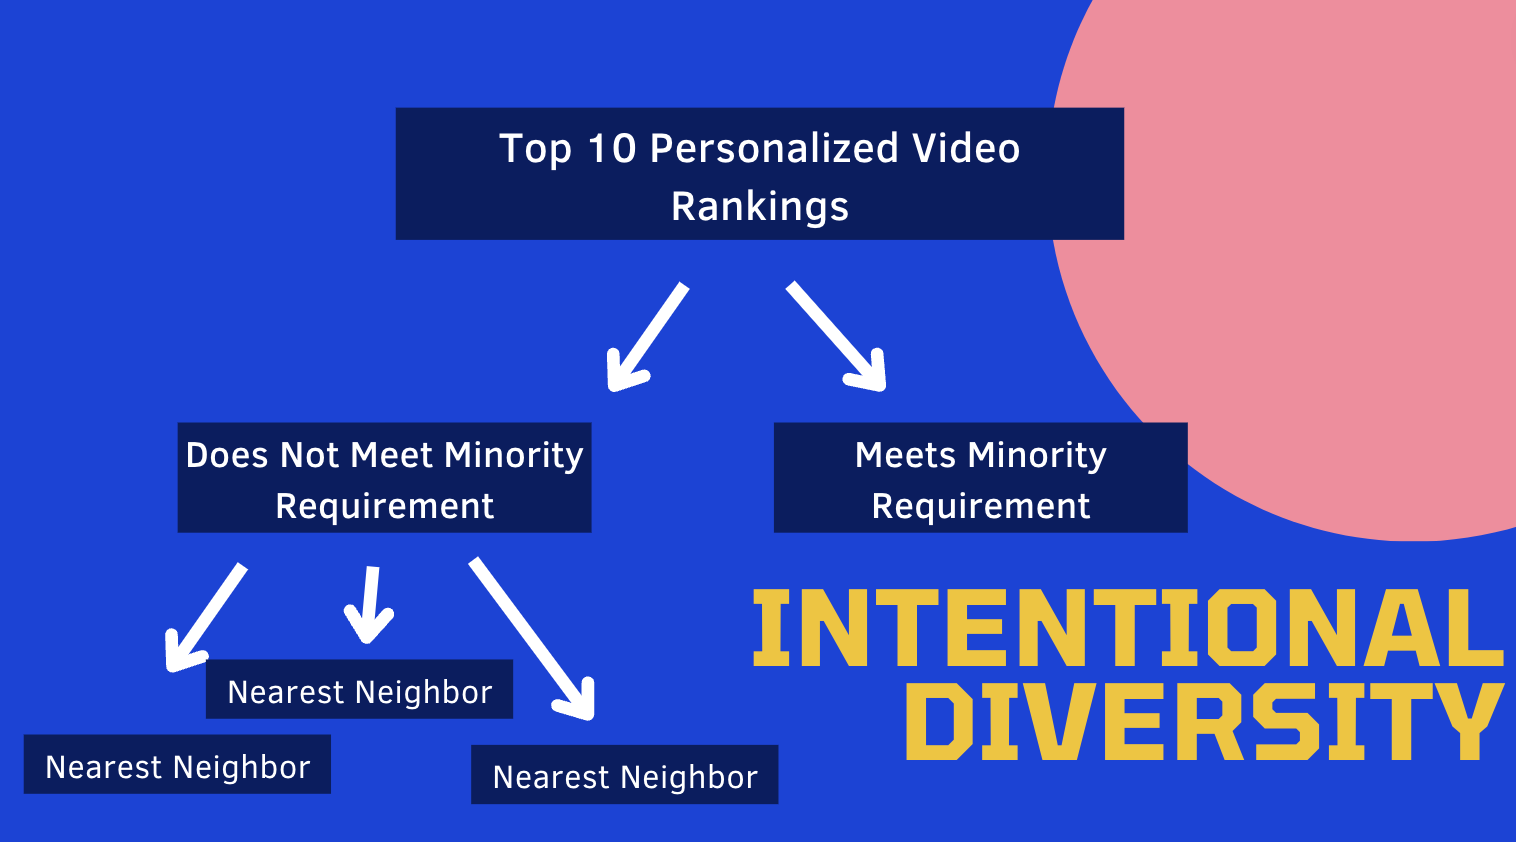

The algorithm then checks for movies in this pre-curated list of Will Smith, Lucy Liu, and Jennifer Lopez movies:

**Will Smith:**
- Hitch (2005): 17324
- Shark Tale (2004): 5345
- Bad Boys (1995): 2186

**Lucy Liu:**
- Mulan 2 (2004): 13836
- Charlie's Angels (2000): 6552

**Jennifer Lopez:**
- Maid in Manhattan (2002): 11149
- Out of Sight (1998): 13486

I have chosen these celebrities as they were very popular in 2005 and tested well in markets throughout middle America and internationally.

If any of the above movies are present among the nearest neighbors, it will boost that movie to the 3rd recommendation in the personal video recommendations.

If none are present, the algorithm will insert Men In Black (2002) as the 3rd recommendation in the personal video recommendations.

**Holdout Will Smith Movie:**
- Men In Black (2002): 12918


# The Models

In [5]:
reader = Reader(rating_scale=(1,5))
all_data = Dataset.load_from_df(data[['cust_id','mid','rating']], reader)

#correct surprise dataset format
all_sr = all_data.build_full_trainset()

In [6]:
#instantiate best Matrix Factorization Model and fit to all data
svdpp = SVDpp(n_factors= 150, n_epochs= 20)
svdpp.fit(all_sr)

In [7]:
#instantiate best kNN Model and fit to all data
sim_dict = {'name': 'cosine', 'user_based': False}
knn = KNNBaseline(min_k=5, sim_options=sim_dict)
knn.fit(all_sr)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [32]:
#list of video ids we will use to infuse racial diversity into our recommendations
diverse_mids = [17324, 5345, 2186, 13836, 6552, 11149, 13486, 12918]

# User #2407458

Throughout this process, I have been tracking the recommendations given to this randomly selected user to illustrate the recommendations provided by the algorithm. 

User 2407458 is a late adopter who may favor videos released in the 1990s.

In [33]:
user_df = data[data['cust_id'] == 2407458]
user1 = 2407458
user_df

mid  cust_id  rating     r_date  m_decade  m_avg_rating   
54936   15342  2407458     3.0 2005-11-17         4      3.476331  \
76944   16128  2407458     4.0 2005-11-05         4      3.964478   
130508  14606  2407458     3.0 2005-11-05         5      3.124744   
698884   4157  2407458     3.0 2005-11-17         4      3.357143   

        user_engagement  cust_act_activity_rank  adopters  m_minreq  
54936                 4                       3         5       0.0  
76944                 4                       3         5       0.0  
130508                4                       3         5       0.0  
698884                4                       3         5       1.0

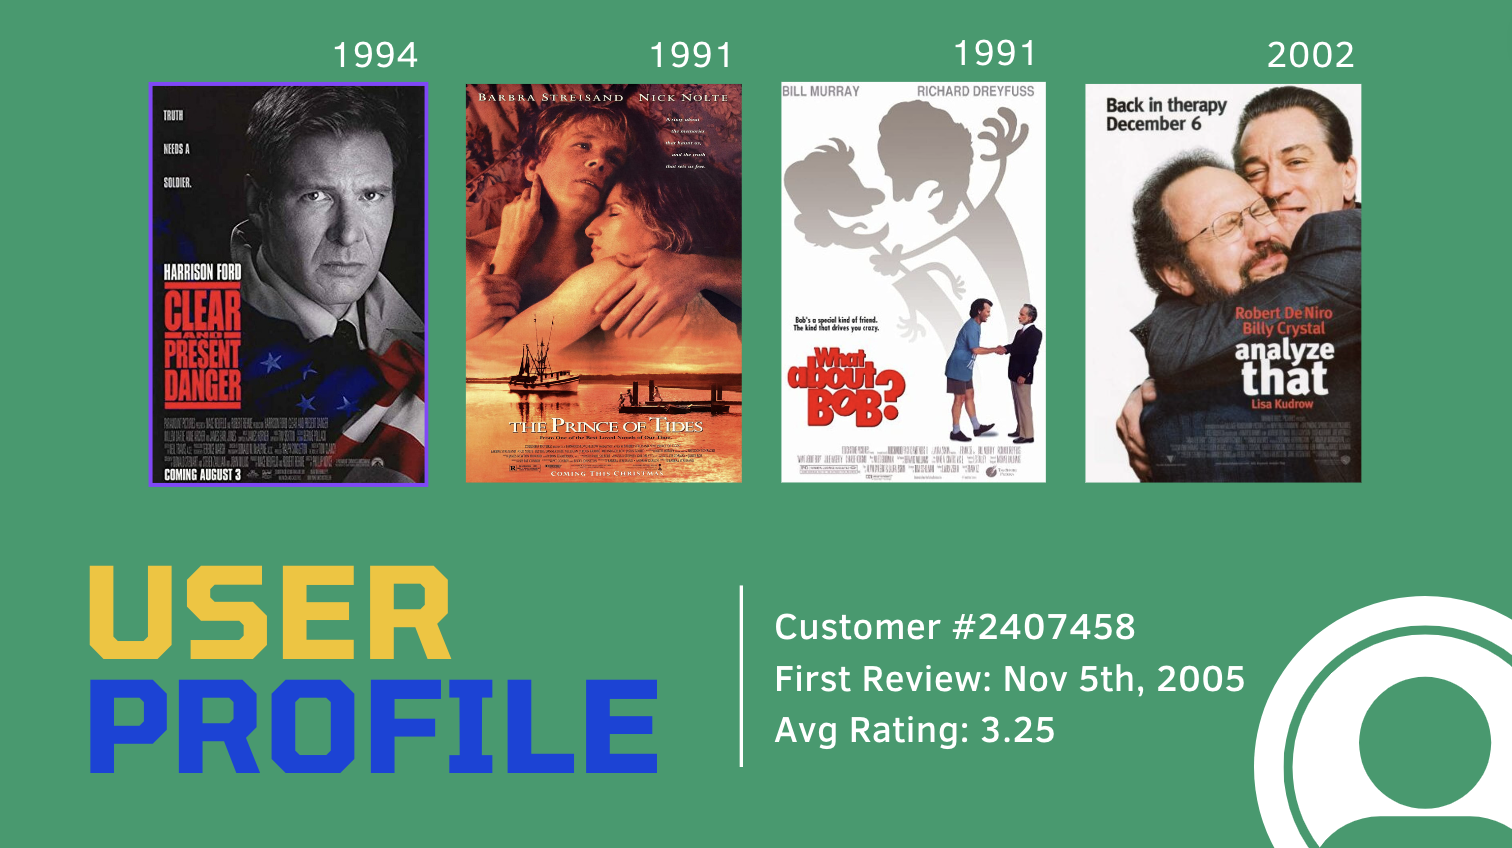

# Personalized Video Ranker

My original PVR was built using collaborative filtering. It looks at what a user has already rated and suggests videos they haven't seen but may rate highly.


In [25]:
def pvr_diversity_check(cust_id):

    def pvr(cust_id):
        all_recs = []

        def rec_pvr(cust_id):

            # list of all content user has not rated
            all_content = data['mid'].unique()
            user_content = data[data['cust_id'] == cust_id]['mid'].unique()
            new_content = list(set(all_content) - set(user_content))

            # predict the ratings for new content
            preds = [svdpp.predict(cust_id, mid) for mid in new_content]

            # sort preds by estimated rating
            preds.sort(key=lambda pred: pred.est, reverse=True)

            # top 10 recommendations
            top_10 = [prediction.iid for prediction in preds[:10]]

            #return list of cust,mid pairs
            return [(cust_id, movie_id) for movie_id in top_10]

        #apply rec_pvr fxn and + to list
        user_recs = rec_pvr(cust_id)
        all_recs.extend(user_recs)

        #new df of recs for analysis including minority requirement
        initial_recs_df = pd.DataFrame(all_recs, columns=["cust_id", "mid"])
        initial_recs_df = initial_recs_df.merge(minorityrec)

        return initial_recs_df

    def diversity_check(initial_recs_df):
    
        def diversity_false(initial_recs_df):

            #list of mids in svdpp ranker
            svdpp_mid_list = list(initial_recs_df['mid'])

            #instantiate list of 10nn for each rec
            hundred_initial_rec_nn = []

            #nearest neighbors for all 10 recs in svdpp ranker
            for mid in svdpp_mid_list:
                #get inner id
                mid_iid = knn.trainset.to_inner_iid(mid)
                #ten nearest neighbor
                ten = knn.get_neighbors(mid_iid, k=10)
                #extend list of nearest neighbors inner ids
                #electing to extend because it's easier than calling another list comprehension later
                hundred_initial_rec_nn.extend(ten)

                '''
                checks if pre-curated list of movie iids
                are in nearest neighbors iid
                '''

                #diversity check Hitch(2005) 17324
                if knn.trainset.to_inner_iid(17324) in hundred_initial_rec_nn:
                    newrow = [cust_id, 17324, 1]

                #diversity check Mulan 2 13836
                elif knn.trainset.to_inner_iid(13836) in hundred_initial_rec_nn:
                    newrow = [cust_id, 113836, 1]

                #diversity check Maid In Manhattan 11149
                elif knn.trainset.to_inner_iid(11149) in hundred_initial_rec_nn:
                    newrow = [cust_id, 11149, 1]

                #diversity check Shark Tale 5345
                elif knn.trainset.to_inner_iid(5345) in hundred_initial_rec_nn:
                    newrow = [cust_id, 5345, 1]

                #diversity check Charlie's Angels 6552
                elif knn.trainset.to_inner_iid(6552) in hundred_initial_rec_nn:
                    newrow = [cust_id, 6552, 1]

                #diversity check Out of Sight 13486
                elif knn.trainset.to_inner_iid(13486) in hundred_initial_rec_nn:
                    newrow = [cust_id, 13486, 1]

                #diversity check Bad Boys 2186
                elif knn.trainset.to_inner_iid(2186) in hundred_initial_rec_nn:
                    newrow = [cust_id, 2186, 1]

                #else return MIB 12918
                else:
                    new_row = [cust_id, 12918, 1]

            #insert new row at index 3
            initial_recs_df.loc[3] = new_row
            initial_recs_df = initial_recs_df.sort_index().reset_index(drop=True)
            return initial_recs_df[:10]

        if 1 in list(initial_recs_df['m_minreq']):
            return initial_recs_df
        else:
            diversity_false(initial_recs_df)
            
    pvr = pvr(cust_id)
    pvr_diversitychecked = diversity_check(pvr)
    
    return pvr_diversitychecked

User 2407458's results for the inital Personal Video Ranker are as follows:

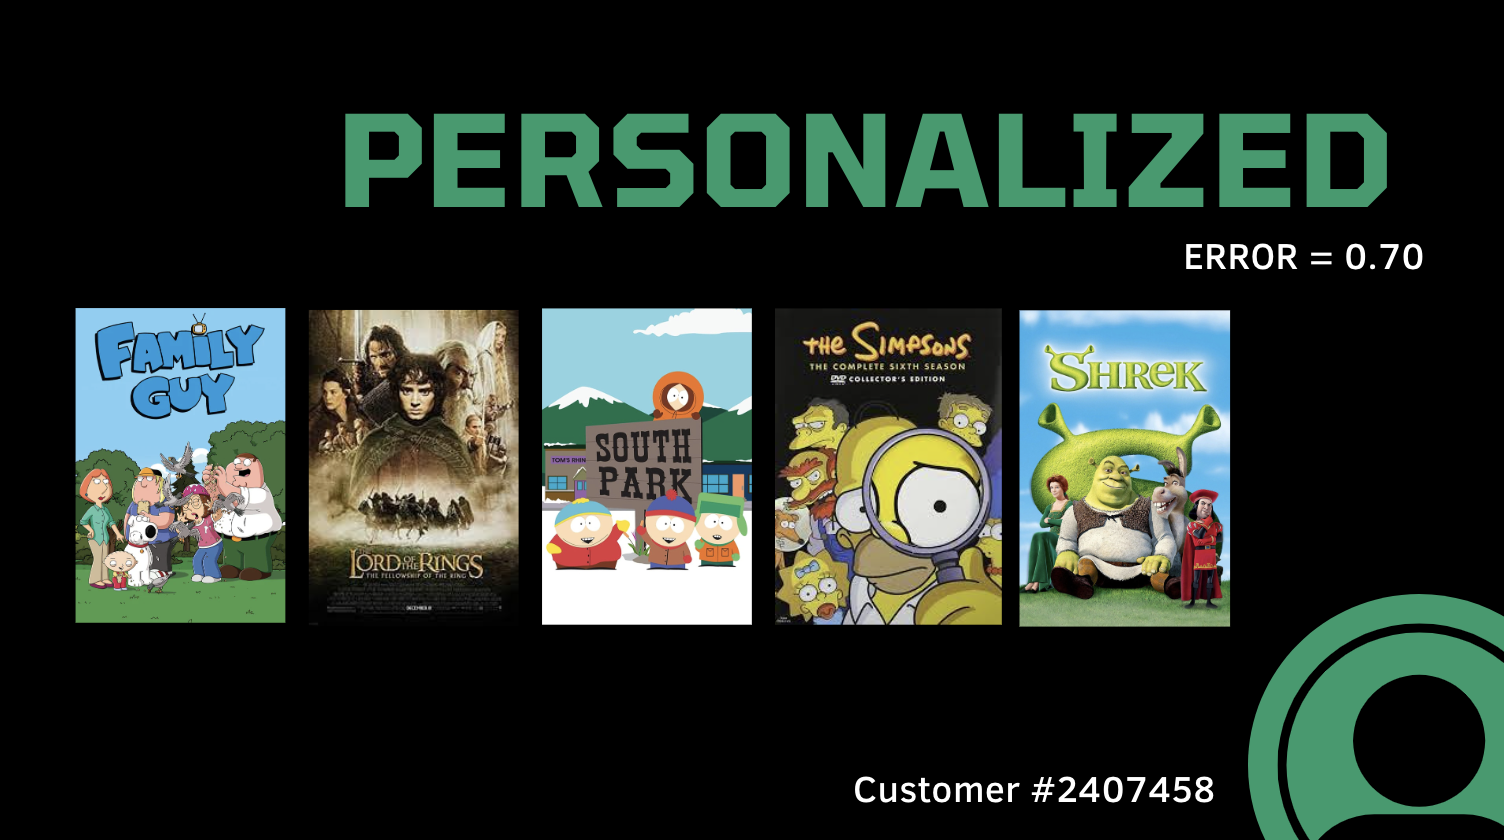

The Intentionally Diverse PVR determined that the Top 10 did not meet the minority requirement. It recommended the following:

In [24]:
pvr_diversity_check(2407458)

cust_id    mid  m_minreq
0  2407458  15861       0.0
1  2407458   8447       0.0
2  2407458   7057       0.0
3  2407458  13273       1.0
4  2407458   2566       0.0
5  2407458   7833       0.0
6  2407458  17307       0.0
7  2407458   8535       0.0
8  2407458   7664       0.0
9  2407458   1256       0.0

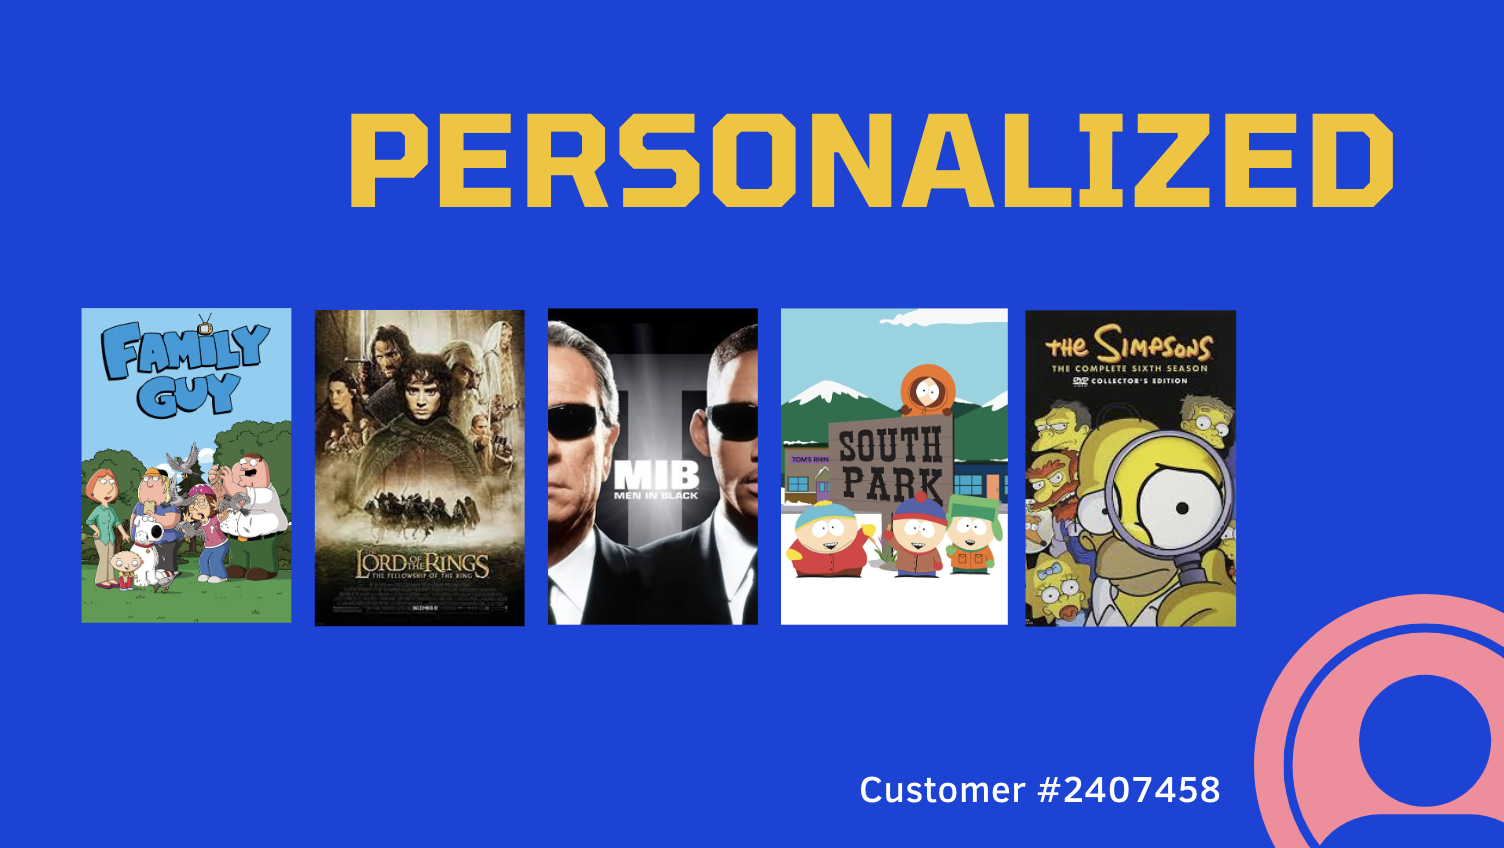

# Video To Video Ranker

V2V Recommenders are unbiased and don't take into account user preferences besides the video that they watched. It recommends content that is alike.

This recommendation algorithm performed well with diversity metrics on it's own. For this project, I have elected to leave it as is.

In [30]:
def v2v_rec(user):
    
    '''
    this is an unpersonalized item based recommendation
    returns a movie that is similar to one that has been watched 
    but doesn't take into account any other user behavior
    '''
        
    # last movie they rated
    rated = data[data['cust_id'] == cust_id]['mid'].to_list()
    mid = rated[-1]

    # neighbors
    neighbors = knn.get_neighbors(all_sr.to_inner_iid(mid), k=10)

    #get raw item ids
    item_ids = [all_sr.to_raw_iid(inner_id) for inner_id in neighbors]

    #returns list of cust_id, iid, neighbor for each neighbor
    neighbors_list = [(cust_id, mid, iid) for iid in item_ids]

    #new df of recs for analysis
    neighbors_df = pd.DataFrame(neighbors_list, columns=["cust_id", "mid", 'recs'])
    return neighbors_df


In [31]:
v2v_rec(2407458)

cust_id   mid   recs
0  2407458  4157   2953
1  2407458  4157  16912
2  2407458  4157   7533
3  2407458  4157   4996
4  2407458  4157   9254
5  2407458  4157  12365
6  2407458  4157  10554
7  2407458  4157   8904
8  2407458  4157  11446
9  2407458  4157   7234

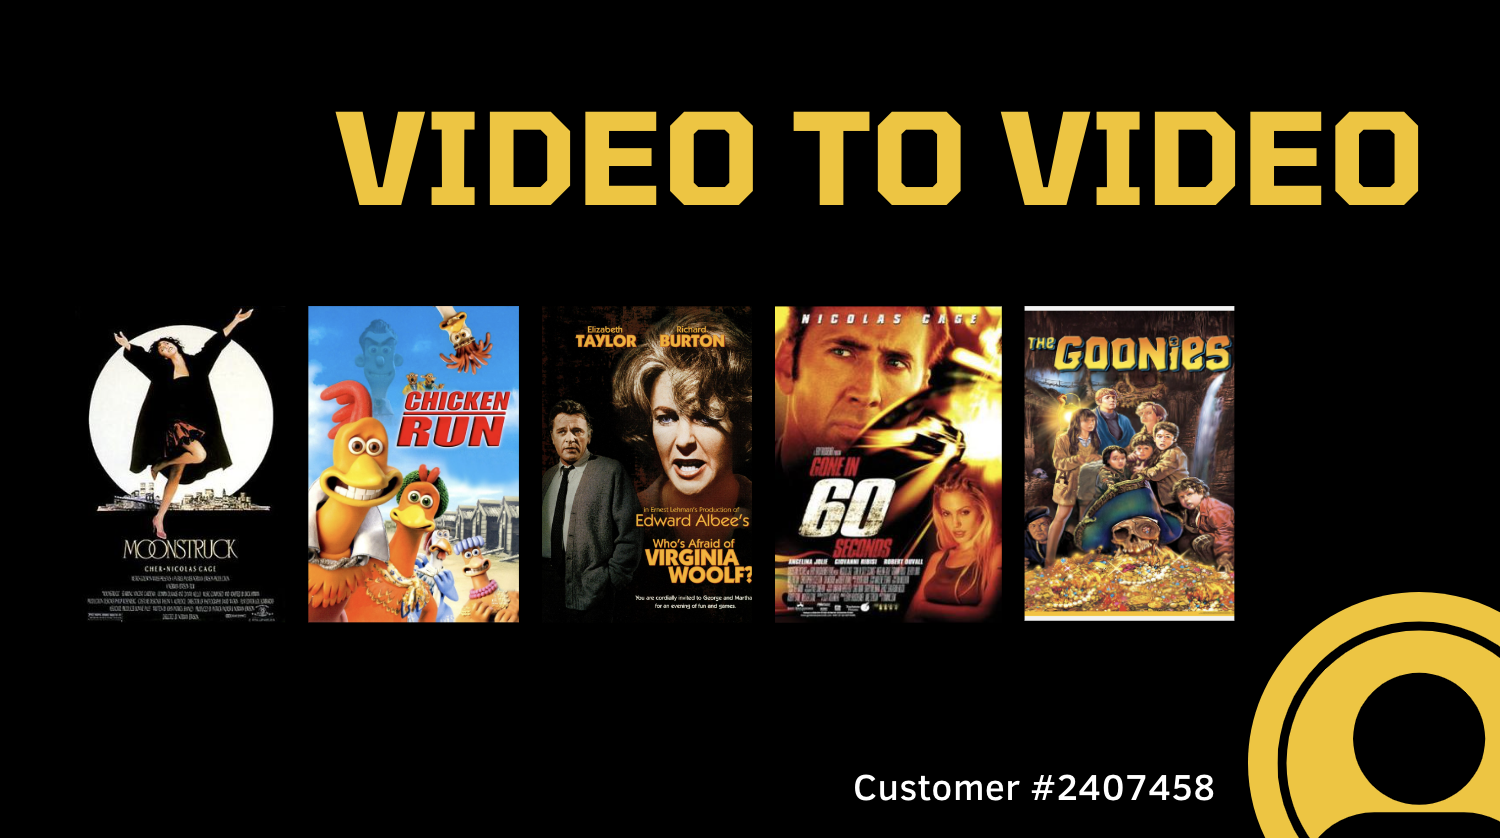

I expected this to do much better in terms of diversity but I was not prepared for how well it would perform.

Though Chicken Run and The Goonies seem out of place here, at least it makes for a more interesting set of recommendations.